In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from EDA import create_boxplot, remove_small_groupings, map_values, one_sample
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from pandas.plotting import boxplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import sem

In [32]:
sat = pd.read_excel('data/UCS-Satellite-Database.xlsx')
sat.head()
print(sat.shape)
sat.dropna(axis=1, how='all', inplace=True)

(6718, 67)


In [33]:
useable_data = sat.columns[0:24]
sat_cleaned = sat[useable_data]
sat_cleaned.head()

,Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),...,Period (minutes),Launch Mass (kg.),Dry Mass (kg.),Power (watts),Date of Launch,Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle
0,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,Infrared Imaging,LEO,Non-Polar Inclined,0.00,...,96.08,22.00,NaN,NaN,2019-12-11 00:00:00,0.50,Hera Systems,USA,Satish Dhawan Space Centre,PSLV
1,Aalto-1,Finland,Finland,Aalto University,Civil,Technology Development,NaN,LEO,Sun-Synchronous,0.00,...,94.70,4.50,NaN,4.50,2017-06-23 00:00:00,2.00,Aalto University,Finland,Satish Dhawan Space Centre,PSLV
2,AAt-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,0.00,...,95.90,1.00,NaN,NaN,2016-04-25 00:00:00,NaN,University of Aalborg,Denmark,Guiana Space Center,Soyuz-2.1a
3,ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,75.00,...,1436.03,6330.00,NaN,16000,2014-02-06 00:00:00,15.00,Space Systems/Loral,USA,Guiana Space Center,Ariane 5 ECA
4,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,-75.00,...,1436.10,1800.00,NaN,NaN,2016-06-15 00:00:00,15.00,Boeing Satellite Systems,USA,Cape Canaveral,Falcon 9


In [34]:
sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6718 entries, 0 to 6717
Data columns (total 67 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Current Official Name of Satellite  6718 non-null   object 
 1   Country/Org of UN Registry          6718 non-null   object 
 2   Country of Operator/Owner           6718 non-null   object 
 3   Operator/Owner                      6718 non-null   object 
 4   Users                               6718 non-null   object 
 5   Purpose                             6718 non-null   object 
 6   Detailed Purpose                    1167 non-null   object 
 7   Class of Orbit                      6718 non-null   object 
 8   Type of Orbit                       6077 non-null   object 
 9   Longitude of GEO (degrees)          6716 non-null   float64
 10  Perigee (km)                        6718 non-null   int64  
 11  Apogee (km)                         6718 no

In [35]:
sat_cleaned.isna().sum()

Current Official Name of Satellite       0
Country/Org of UN Registry               0
Country of Operator/Owner                0
Operator/Owner                           0
Users                                    0
Purpose                                  0
Detailed Purpose                      5551
Class of Orbit                           0
Type of Orbit                          641
Longitude of GEO (degrees)               2
Perigee (km)                             0
Apogee (km)                              0
Eccentricity                             0
Inclination (degrees)                    0
Period (minutes)                        44
Launch Mass (kg.)                      243
Dry Mass (kg.)                        6274
Power (watts)                         6137
Date of Launch                           0
Expected Lifetime (yrs.)              1914
Contractor                               0
Country of Contractor                    0
Launch Site                              0
Launch Vehi

In [36]:
sat_cleaned.drop(['Detailed Purpose', 'Dry Mass (kg.)', 'Power (watts)'],axis=1, inplace= True)
sat_cleaned = remove_small_groupings(sat_cleaned,'Users',1)
sat_cleaned.dropna(subset='Expected Lifetime (yrs.)', inplace=True)

In [37]:
sat_cleaned['Users'].value_counts()

Commercial               4097
Government                280
Military                  148
Government/Commercial      96
Military/Commercial        77
Military/Government        54
Government/Civil           23
Civil                      19
Government/Military         3
Military/Civil              2
Civil/Government            1
Commercial/Military         1
Name: Users, dtype: int64

In [38]:
sat_cleaned['Purpose'].value_counts()
comms_df = sat_cleaned[sat_cleaned['Purpose'] == 'Communications'].sort_values('Date of Launch', ascending=False)
comms_df['Contractor'].value_counts()

SpaceX                                          2853
OneWeb Satellites/Airbus                         502
Space Systems/Loral                               88
Swarm Technologies                                84
Thales Alenia Space/Orbital ATK                   75
                                                ... 
Northrup Grumman Innovation Systems                1
Airbus Defense and Space/Thales Alenia Space       1
Airbus                                             1
EADS B                                             1
TRW, Defense and Space Systems Group               1
Name: Contractor, Length: 70, dtype: int64

In [39]:

# mil_df = sat_cleaned[sat_cleaned['Users']!='Commercial']
mil_df = sat_cleaned
mil_df['Purpose'].value_counts()


Communications                                    4064
Earth Observation                                  461
Navigation/Global Positioning                      140
Space Science                                       50
Technology Development                              42
Navigation/Regional Positioning                     12
Earth Observation/Navigation                         9
Earth Science                                        7
Technology Demonstration                             6
Earth Observation                                    3
Earth Observation/Technology Development             2
Earth Observation/Space Science                      1
Communications/Navigation                            1
Communications/Technology Development                1
Earth Observation/Communications/Space Science       1
Space Observation                                    1
Name: Purpose, dtype: int64

In [40]:
mil_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 6715
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Current Official Name of Satellite  4801 non-null   object 
 1   Country/Org of UN Registry          4801 non-null   object 
 2   Country of Operator/Owner           4801 non-null   object 
 3   Operator/Owner                      4801 non-null   object 
 4   Users                               4801 non-null   object 
 5   Purpose                             4801 non-null   object 
 6   Class of Orbit                      4801 non-null   object 
 7   Type of Orbit                       4276 non-null   object 
 8   Longitude of GEO (degrees)          4801 non-null   float64
 9   Perigee (km)                        4801 non-null   int64  
 10  Apogee (km)                         4801 non-null   int64  
 11  Eccentricity                        4801 no

746.9058429319372
742.8609456363257


array([[<Axes: xlabel='Launch Mass (kg.)', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='Expected Lifetime (yrs.)', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='UsersMap', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='OrbitTypeMap', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='PurposeMaps', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='OrbitClassMap', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='CountryMap', ylabel='Launch Mass (kg.)'>],
       [<Axes: xlabel='Launch Mass (kg.)', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='Expected Lifetime (yrs.)', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='UsersMap', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='OrbitTypeMap', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='PurposeMaps', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='OrbitClassMap', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='CountryMap', ylabel='Expected Lifetime 

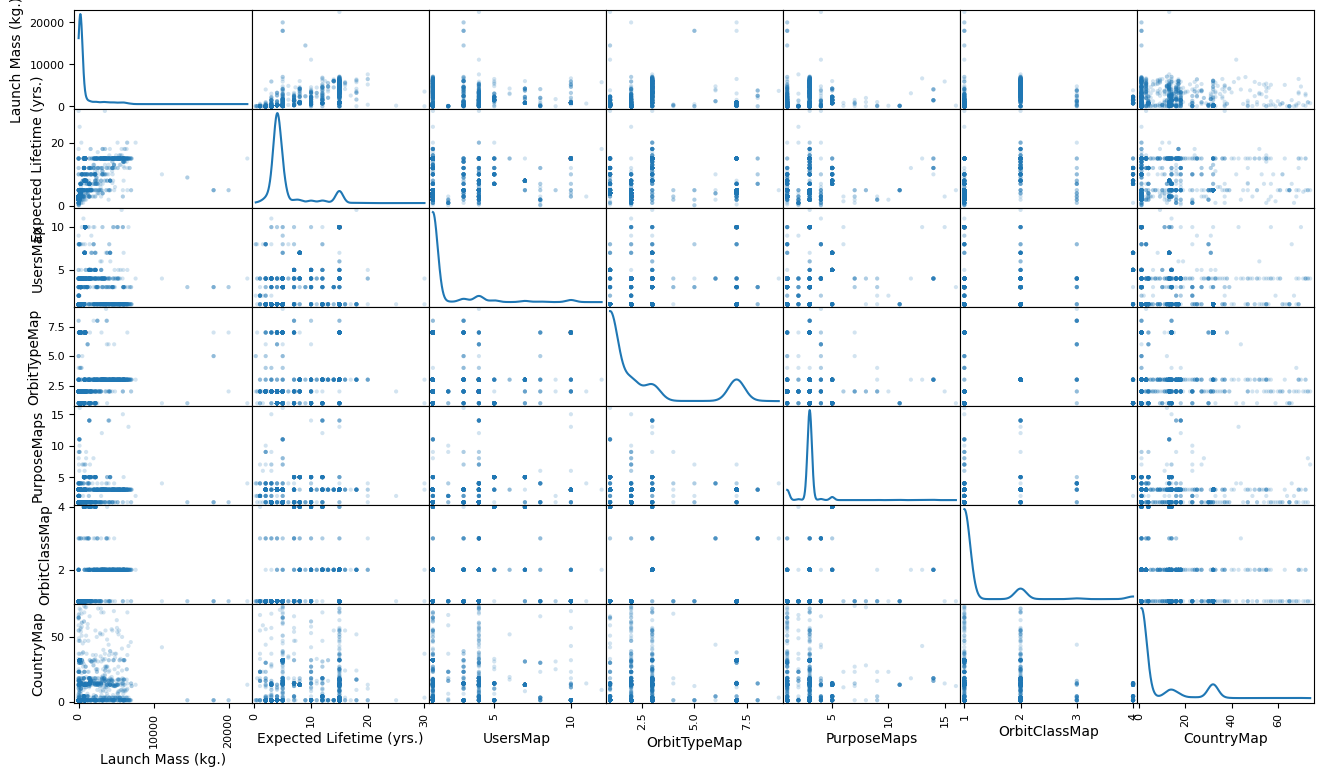

In [41]:
mil_df_scatter = mil_df[['Users','Purpose','Class of Orbit','Type of Orbit', 'Launch Mass (kg.)','Country of Operator/Owner','Expected Lifetime (yrs.)']]
# mil_df_scatter['Expected Lifetime (yrs.)'].fillna(mil_df_scatter['Expected Lifetime (yrs.)'].median(), inplace=True)
mil_df_scatter['Type of Orbit'] = mil_df_scatter['Type of Orbit'].fillna('Unknown')
mil_df_scatter['UsersMap'] = map_values(mil_df_scatter,'Users')
mil_df_scatter['OrbitTypeMap'] = map_values(mil_df_scatter,'Type of Orbit')
mil_df_scatter['PurposeMaps'] = map_values(mil_df_scatter,'Purpose')
mil_df_scatter['OrbitClassMap'] = map_values(mil_df_scatter,'Class of Orbit')
mil_df_scatter['CountryMap'] = map_values(mil_df_scatter,'Country of Operator/Owner')
mil_df_scatter.isna().sum()
print(mil_df_scatter['Launch Mass (kg.)'].mean())
mil_df_scatter['Launch Mass (kg.)'] = mil_df_scatter['Launch Mass (kg.)'].fillna(0)
print(mil_df_scatter['Launch Mass (kg.)'].mean())

scatter_matrix(mil_df_scatter,diagonal='kde', alpha =.2, figsize=(16,9))

In [42]:
mil_df_scatter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 6715
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Users                      4801 non-null   object 
 1   Purpose                    4801 non-null   object 
 2   Class of Orbit             4801 non-null   object 
 3   Type of Orbit              4801 non-null   object 
 4   Launch Mass (kg.)          4801 non-null   float64
 5   Country of Operator/Owner  4801 non-null   object 
 6   Expected Lifetime (yrs.)   4801 non-null   float64
 7   UsersMap                   4801 non-null   int64  
 8   OrbitTypeMap               4801 non-null   int64  
 9   PurposeMaps                4801 non-null   int64  
 10  OrbitClassMap              4801 non-null   int64  
 11  CountryMap                 4801 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 487.6+ KB


## OLS MODEL

In [43]:

X = sm.add_constant(mil_df_scatter[['UsersMap','OrbitTypeMap','PurposeMaps','OrbitClassMap','CountryMap','Launch Mass (kg.)']])
y = mil_df_scatter['Expected Lifetime (yrs.)']
# Step 3: Build the OLS model
ols_model = sm.OLS(y, X)
results = ols_model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Expected Lifetime (yrs.)   R-squared:                       0.588
Model:                                  OLS   Adj. R-squared:                  0.588
Method:                       Least Squares   F-statistic:                     1140.
Date:                      Fri, 04 Aug 2023   Prob (F-statistic):               0.00
Time:                              11:02:06   Log-Likelihood:                -10814.
No. Observations:                      4801   AIC:                         2.164e+04
Df Residuals:                          4794   BIC:                         2.169e+04
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

<Axes: xlabel='predicted', ylabel='residuals'>

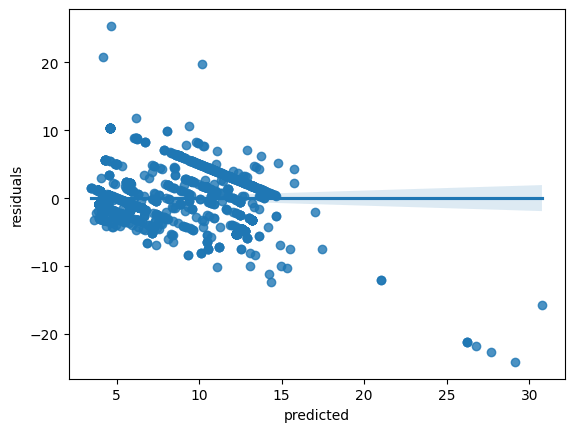

In [44]:
mil_df_scatter['predicted'] = results.predict(X)
mil_df_scatter['residuals'] = y - mil_df_scatter['predicted']

# Created regression plot
sns.regplot(x=mil_df_scatter['predicted'], y=mil_df_scatter['residuals'])

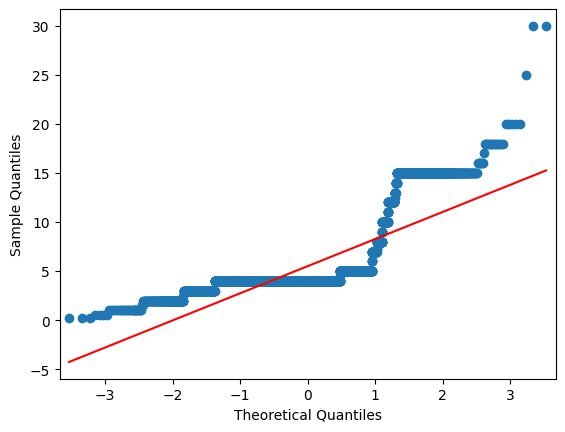

In [45]:
mil_sorted = y.sort_values()
sm.qqplot(mil_sorted, line='r');

## Predicted vs Residuals

#### Hetero

## Power

### Life Expectancy Distribution

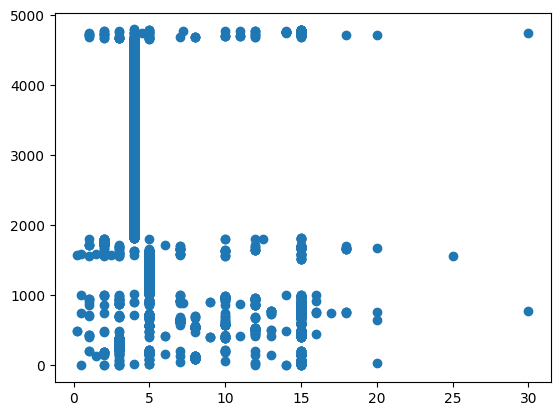

In [46]:
plt.scatter(y, range(len(y)))

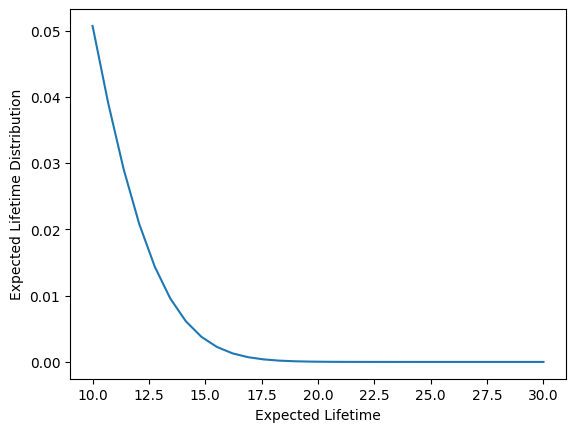

5.5042178712768175


In [47]:
life_mean = y.mean()
life_std = np.std(y)
life_dist= stats.norm.pdf(life_mean,life_std)
# sns.kdeplot(bot_dist)
x = np.linspace(10, 30, 30)

plt.plot(x, stats.norm.pdf(x, loc=life_mean, scale=life_std))
plt.xlabel("Expected Lifetime")
plt.ylabel("Expected Lifetime Distribution")
plt.show()
print(life_mean)


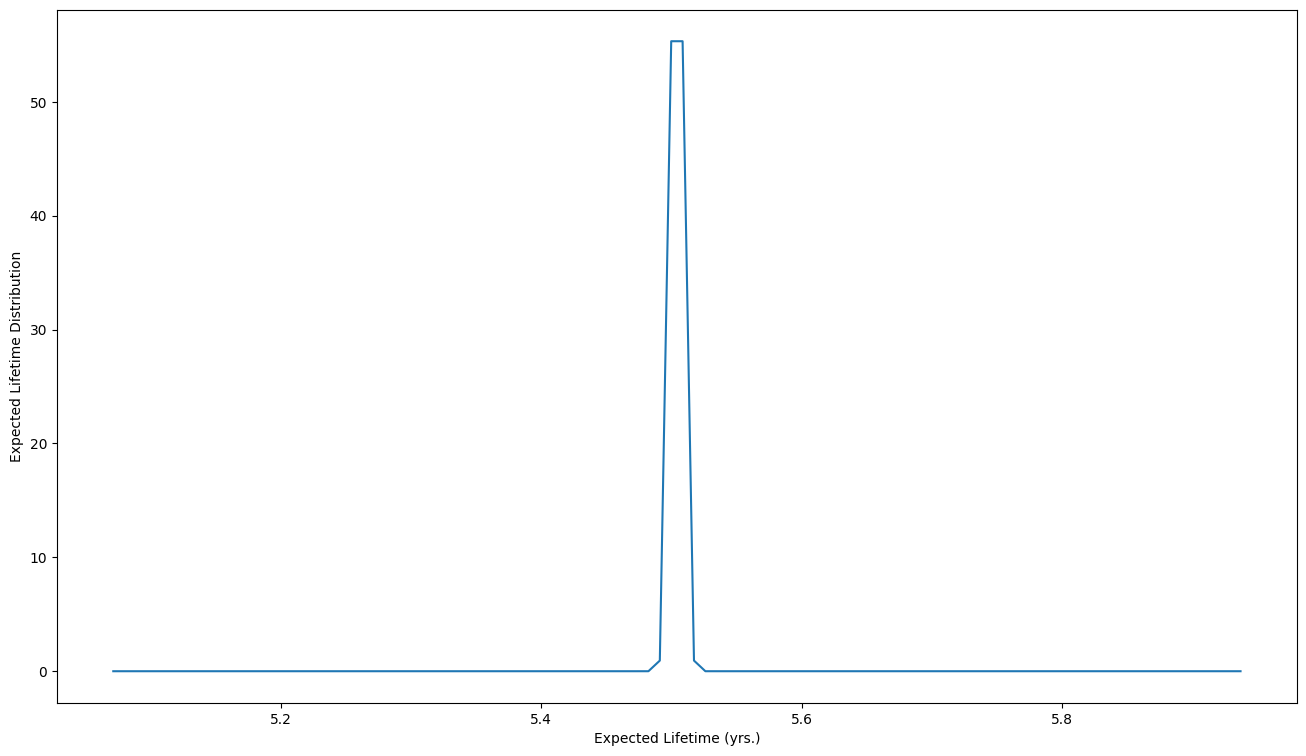

0.0043296760344894835


In [54]:
SE = np.sqrt(.1*(1-.1)/len(y))
x = np.linspace(life_mean - 4 * SE, life_mean + 4 * SE,num=100)
plt.figure(figsize=(16,9))
plt.plot(x, stats.norm.pdf(x, loc=life_mean, scale=SE))
plt.xlabel("Expected Lifetime (yrs.)")
plt.ylabel("Expected Lifetime Distribution")
plt.show()
print(SE)

## Regression Model

In [49]:
# Get the model parameters (coefficients)
intercept = results.params['const']
coefficients = results.params.drop('const')

# Step 4: Create the linear regression model
linear_model = LinearRegression()
linear_model.intercept_ = intercept
linear_model.coef_ = coefficients.to_numpy()

# Step 5: Evaluate the model
# Predict on the test set
y_pred = linear_model.predict(X_test)

# Calculate mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
# Step 6: Graph the linear regression model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Expected Lifetime (yrs.)')
plt.ylabel('Predicted Expected Lifetime (yrs.)')
plt.title('Linear Regression Model - Actual vs. Predicted')
plt.text(min(y_test), max(y_test), f'R-squared: {r2:.2f}\nMean Squared Error: {mse:.2f}', va='top', ha='left', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)
plt.show()

NameError: name 'X_test' is not defined

## Confusion Map

c:\Users\beans\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


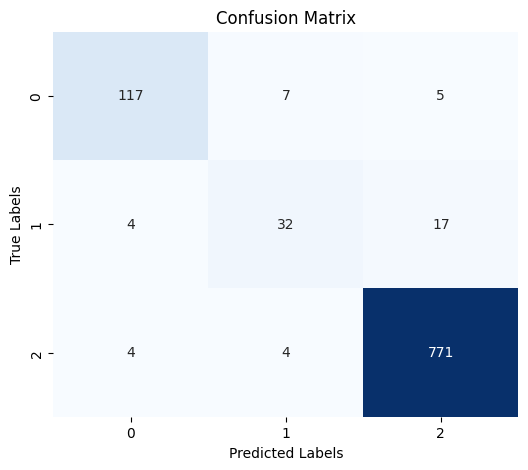

In [50]:
mil_df_scatter['Lifetime Class'] = pd.cut(mil_df_scatter['Expected Lifetime (yrs.)'], bins=[-np.inf, 5, 10, np.inf], labels=['Short', 'Medium', 'Long'])

# Prepare the data
X = mil_df_scatter[['Users', 'Purpose', 'Class of Orbit', 'Type of Orbit', 'Launch Mass (kg.)', 'Country of Operator/Owner']]
y = mil_df_scatter['Lifetime Class']

# Encode categorical variables using get_dummies
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
mil_dummy = pd.get_dummies(mil_df_scatter, columns=['Users', 'Purpose', 'Class of Orbit', 'Type of Orbit', 'Country of Operator/Owner'])

# Handle missing values in the 'Expected Lifetime (yrs.)' column
# For this example, we will fill missing values with the median
mil_dummy['Expected Lifetime (yrs.)'].fillna(mil_dummy['Expected Lifetime (yrs.)'].median(), inplace=True)

# Split the data into training and testing sets
X = mil_dummy.drop(columns=['Expected Lifetime (yrs.)'])
y = mil_dummy['Expected Lifetime (yrs.)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Build the OLS model
X_train = sm.add_constant(X_train)  # Add constant term for intercept
ols_model = sm.OLS(y_train, X_train)

# Step 3: Fit the model
results = ols_model.fit()

# Get the model parameters (coefficients)
intercept = results.params['const']
coefficients = results.params.drop('const')

# Step 4: Create the linear regression model
linear_model = LinearRegression()
linear_model.intercept_ = intercept
linear_model.coef_ = coefficients.to_numpy()

# Step 5: Evaluate the model
# Predict on the test set
y_pred = linear_model.predict(X_test)

# Calculate mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
# Step 6: Graph the linear regression model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Expected Lifetime (yrs.)')
plt.ylabel('Predicted Expected Lifetime (yrs.)')
plt.title('Linear Regression Model - Actual vs. Predicted')
plt.text(min(y_test), max(y_test), f'R-squared: {r2:.2f}\nMean Squared Error: {mse:.2f}', va='top', ha='left', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)
plt.show()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const                                             float64
Launch Mass (kg.)                                 float64
UsersMap                                            int64
OrbitTypeMap                                        int64
PurposeMaps                                         int64
                                                   ...   
Country of Operator/Owner_United Arab Emirates      uint8
Country of Operator/Owner_United Kingdom            uint8
Country of Operator/Owner_United Kingdom/ESA        uint8
Country of Operator/Owner_Venezuela                 uint8
Country of Operator/Owner_Vietnam                   uint8
Length: 125, dtype: object. The data was
4423    4.00
4834    4.00
6149    4.00
2788    2.00
3528    4.00
        ... 
5998    4.00
706    15.00
4664    4.00
5344    4.00
1247   12.00
Name: Expected Lifetime (yrs.), Length: 3840, dtype: float64
and
       const  Launch Mass (kg.)  UsersMap  OrbitTypeMap  PurposeMaps  \
4423   1.00             260.00         1             7            3   
4834   1.00             260.00         1             1            3   
6149   1.00             260.00         1             1            3   
2788   1.00               2.00         1             2            3   
3528   1.00             260.00         1             1            3   
...     ...                ...       ...           ...          ...   
5998   1.00             260.00         1             1            3   
706    1.00            3461.00         1             3            3   
4664   1.00             260.00         1             1            3   
5344   1.00             260.00         1             1            3   
1247   1.00            1432.00         4             3           14   

      OrbitClassMap  CountryMap  predicted  residuals Lifetime Class  ...  \
4423              1           1       5.81      -1.81          Short  ...   
4834              1           1       4.09      -0.09          Short  ...   
6149              1           1       4.09      -0.09          Short  ...   
2788              1           1       4.08      -2.08          Short  ...   
3528              1           1       4.09      -0.09          Short  ...   
...             ...         ...        ...        ...            ...  ...   
5998              1           1       4.09      -0.09          Short  ...   
706               2           3      10.25       4.75           Long  ...   
4664              1           1       4.09      -0.09          Short  ...   
5344              1           1       4.09      -0.09          Short  ...   
1247              2          18       9.53       2.47           Long  ...   

      Country of Operator/Owner_USA/France  \
4423                                     0   
4834                                     0   
6149                                     0   
2788                                     0   
3528                                     0   
...                                    ...   
5998                                     0   
706                                      0   
4664                                     0   
5344                                     0   
1247                                     0   

      Country of Operator/Owner_USA/Germany  \
4423                                      0   
4834                                      0   
6149                                      0   
2788                                      0   
3528                                      0   
...                                     ...   
5998                                      0   
706                                       0   
4664                                      0   
5344                                      0   
1247                                      0   

      Country of Operator/Owner_USA/Japan  \
4423                                    0   
4834                                    0   
6149                                    0   
2788                                    0   
3528                                    0   
...                                   ...   
5998                                    0   
706                                     0   
4664                                    0   
5344                                    0   
1247                                    0   

      Country of Operator/Owner_USA/Japan/Brazil  \
4423                                           0   
4834                                           0   
6149                                           0   
2788                                           0   
3528                                           0   
...                                          ...   
5998                                           0   
706                                            0   
4664                                           0   
5344                                           0   
1247                                           0   

      Country of Operator/Owner_USA/United Kingdom/Italy  \
4423                                                  0    
4834                                                  0    
6149                                                  0    
2788                                                  0    
3528                                                  0    
...                                                 ...    
5998                                                  0    
706                                                   0    
4664                                                  0    
5344                                                  0    
1247                                                  0    

      Country of Operator/Owner_United Arab Emirates  \
4423                                               0   
4834                                               0   
6149                                               0   
2788                                               0   
3528                                               0   
...                                              ...   
5998                                               0   
706                                                0   
4664                                               0   
5344                                               0   
1247                                               0   

      Country of Operator/Owner_United Kingdom  \
4423                                         0   
4834                                         0   
6149                                         0   
2788                                         0   
3528                                         0   
...                                        ...   
5998                                         0   
706                                          0   
4664                                         0   
5344                                         0   
1247                                         0   

      Country of Operator/Owner_United Kingdom/ESA  \
4423                                             0   
4834                                             0   
6149                                             0   
2788                                             0   
3528                                             0   
...                                            ...   
5998                                             0   
706                                              0   
4664                                             0   
5344                                             0   
1247                                             0   

      Country of Operator/Owner_Venezuela  Country of Operator/Owner_Vietnam  
4423                                    0                                  0  
4834                                    0                                  0  
6149                                    0                                  0  
2788                                    0                                  0  
3528                                    0                                  0  
...                                   ...                                ...  
5998                                    0                                  0  
706                                     0                                  0  
4664                                    0                                  0  
5344                                    0                                  0  
1247                                    0                                  0  

[3840 rows x 125 columns]
before. After,
[ 4.  4.  4. ...  4.  4. 12.]
[[1.0 260.0 1 ... 0 0 0]
 [1.0 260.0 1 ... 0 0 0]
 [1.0 260.0 1 ... 0 0 0]
 ...
 [1.0 260.0 1 ... 0 0 0]
 [1.0 260.0 1 ... 0 0 0]
 [1.0 1432.0 4 ... 0 0 0]].

## Critical Value

In [ ]:


from scipy.stats import norm
# mil_distribution = norm(loc=np.mean(practice_mil), scale=np.std(practice_mil)/(len(practice_mil)))
mil_distribution = norm(loc=np.mean(practice_mil), scale=np.std(practice_mil, ddof=1))
# civ_distribution = norm(loc=np.mean(practice_civ), scale=np.std(practice_civ)/(len(practice_civ)))
civ_distribution = norm(loc=np.mean(practice_civ), scale=np.std(practice_civ, ddof=1))
critical_value = civ_distribution.ppf(0.025)
critical_value2 = civ_distribution.ppf(0.975)
# critical_value = null_distribution.ppf(0.95)

print(critical_value, critical_value2)

norm_mil = norm.fit(practice_mil)
# gives mean and standard deviation of the array you give it